In [1]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import time

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner
from learn_KKL.raffinement_dimN import *
#sb.set_style('whitegrid')

torch.Size([280, 4])


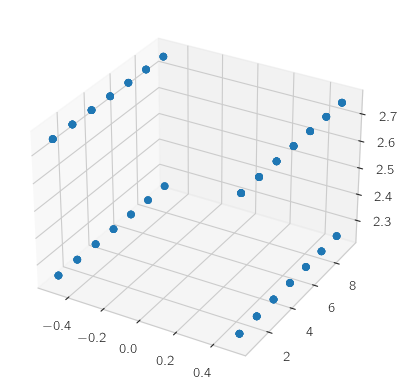

In [14]:
import matplotlib.pyplot as plt
from learn_KKL.utils import generate_mesh
mesh,grid = generate_mesh(np.array([[-1,1],[-1,1],[0,10],[2,3]]),[10,2,7,2],method="adaptative")
print(mesh.shape)
ax = plt.axes(projection='3d')
ax.scatter3D(mesh[:,1],mesh[:,2],mesh[:,3])
plt.show()

In [3]:
# Set up the system
system = RevDuffing()

In [47]:
# Instantiate the observer
start = time.time()
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised', recon_lambda=0.8, wc=0.03,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate (x_i, z_i) data by running system backward, then system + observer
# forward in time
data,grid = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [50,50],
                                  method='adaptative')
end = time.time()
print("temps de génération des données : ",int((end - start) / 60), "min et", end - start - 60 * int((end - start) / 60), "s")

temps de génération des données :  4 min et 51.555015325546265 s


torch.Size([2500, 5])


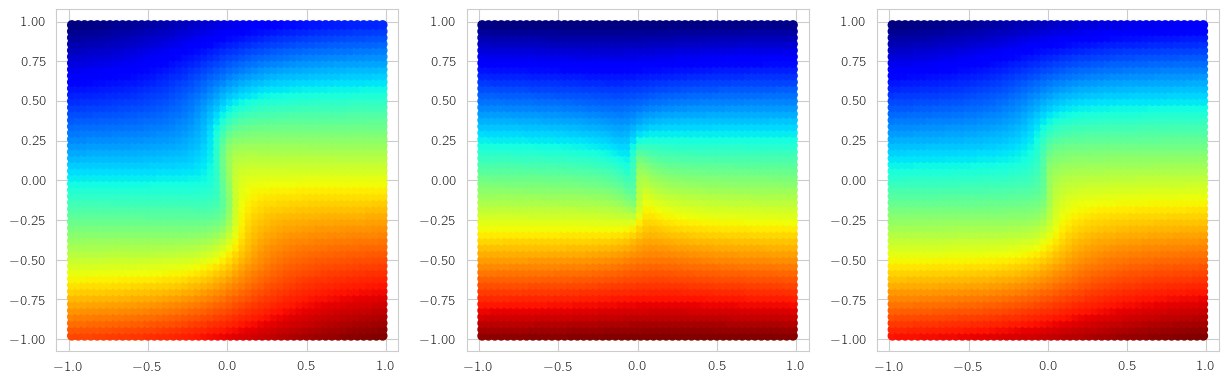

In [48]:
print(data.shape)
im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(data[:,0],data[:,1],c = data[:,2+i],cmap='jet')
    ax[i].axis('square')
plt.show()

C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1017324458.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[0],shrink=0.4)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1017324458.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[1],shrink=0.4)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1017324458.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[2],shrink=0.4)


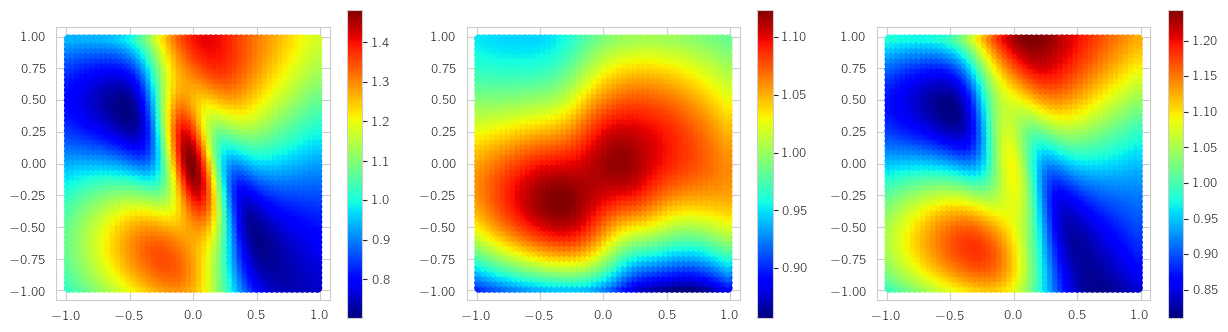

In [55]:
from functorch import vmap, jacfwd
dTdx = vmap(jacfwd(observer.encoder))(data[:,0:2]).detach()
dT1 = np.sqrt(dTdx[:,0,0]**2+dTdx[:,0,1]**2)
dT2 = np.sqrt(dTdx[:,1,0]**2+dTdx[:,1,1]**2)
dT3 = np.sqrt(dTdx[:,2,0]**2+dTdx[:,2,1]**2)

im,ax = plt.subplots(1,3,figsize=(15,10))
pc=ax[0].scatter(data[:,0],data[:,1],c = dT1,cmap='jet')
ax[0].axis('square')
im.colorbar(pc,ax=ax[0],shrink=0.4)

pc=ax[1].scatter(data[:,0],data[:,1],c = dT2,cmap='jet')
ax[1].axis('square')
im.colorbar(pc,ax=ax[1],shrink=0.4)

pc=ax[2].scatter(data[:,0],data[:,1],c = dT3,cmap='jet')
ax[2].axis('square')
im.colorbar(pc,ax=ax[2],shrink=0.4)

plt.show()

C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1965002443.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[0],shrink=0.7)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1965002443.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[1],shrink=0.7)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1965002443.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[0,i],shrink=0.7)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1965002443.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcol

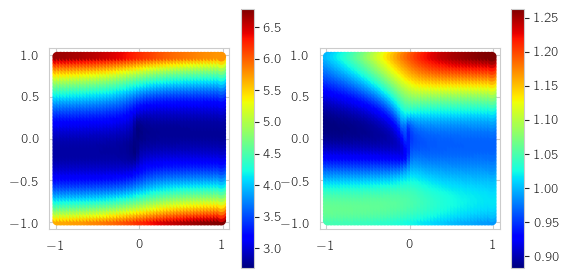

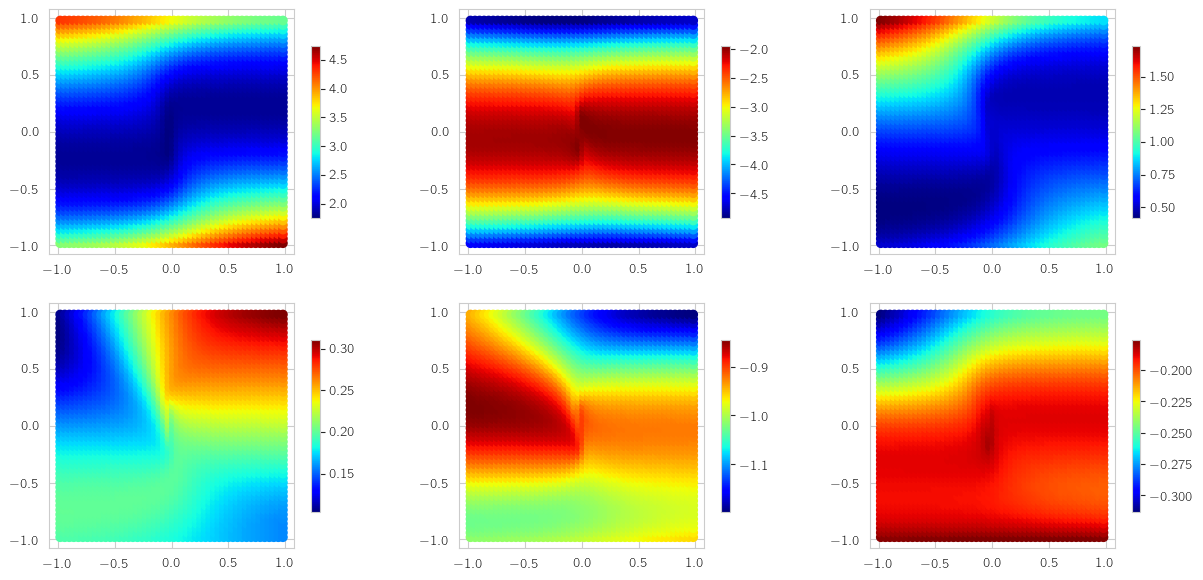

In [56]:
dTdz = vmap(jacfwd(observer.decoder))(data[:,2:5]).detach()
dT1 = np.sqrt(dTdz[:,0,0]**2+dTdz[:,0,1]**2+dTdz[:,0,2]**2)
dT2 = np.sqrt(dTdz[:,1,0]**2+dTdz[:,1,1]**2+dTdz[:,1,2]**2)

im,ax = plt.subplots(1,2)
pc=ax[0].scatter(data[:,0],data[:,1],c = dT1,cmap='jet')
ax[0].axis('square')
im.colorbar(pc,ax=ax[0],shrink=0.7)

pc=ax[1].scatter(data[:,0],data[:,1],c = dT2,cmap='jet')
ax[1].axis('square')
im.colorbar(pc,ax=ax[1],shrink=0.7)

im,ax = plt.subplots(2,3,figsize=(15,7))
for i in range(3):
    pc=ax[0,i].scatter(data[:,0],data[:,1],c = dTdz[:,0,i],cmap='jet')
    ax[0,i].axis('square')
    im.colorbar(pc,ax=ax[0,i],shrink=0.7)

    pc=ax[1,i].scatter(data[:,0],data[:,1],c = dTdz[:,1,i],cmap='jet')
    ax[1,i].axis('square')
    im.colorbar(pc,ax=ax[1,i],shrink=0.7)
plt.show()

In [49]:
data_init, val_data_init = train_test_split(data, test_size=0.3, shuffle=True)

In [50]:
# Train the forward transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data_init,
                    validation_data=val_data_init, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_59/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_59


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

In [52]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_init,
                         validation_data=val_data_init, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_59/tb_logs\lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_26


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-06.


RMSE :  [0.00376862 0.00023677]


C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\1203686658.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[i],shrink=0.3)


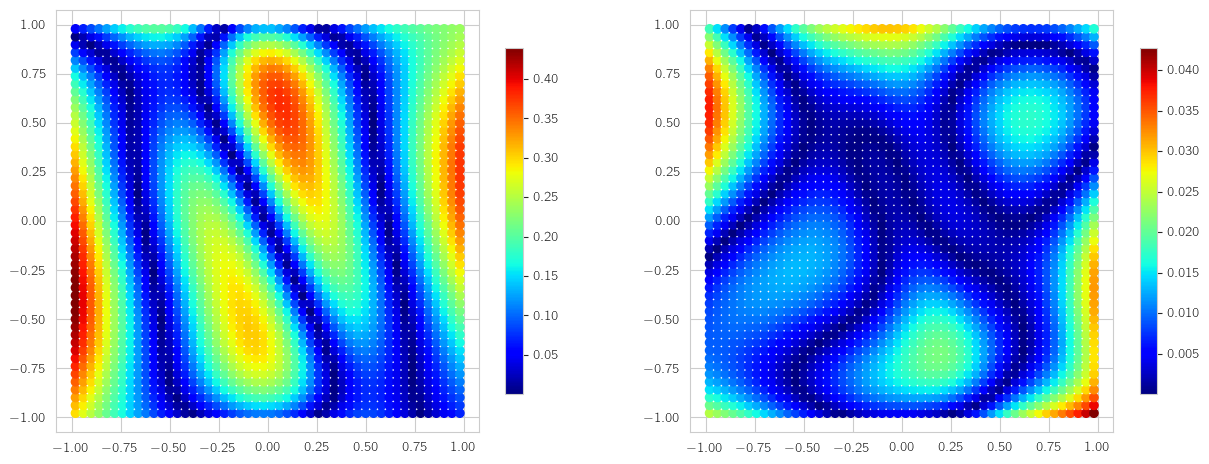

In [53]:
# Calcul du critère de raffinement
mesh = data[:,0:2]
mesh = torch.as_tensor(mesh)
z_hat = observer.encoder(mesh).detach()
x_hat = observer.decoder(z_hat).detach()
error = torch.abs(mesh-x_hat)
rmse = np.array([torch.sqrt((error[:,0]**2).sum()),torch.sqrt((error[:,1]**2).sum())])/error[:,0].size()
print("RMSE : ",rmse)

vmin1,vmax1,vmin2,vmax2 = error[:,0].min(),error[:,0].max(),error[:,1].min(),error[:,1].max()

im,ax = plt.subplots(1,2,figsize=(15,15))
for i in range(2):
    pc=ax[i].scatter(mesh[:,0],mesh[:,1],c = error[:,i],cmap='jet')
    ax[i].axis('square')
    im.colorbar(pc,ax=ax[i],shrink=0.3)
plt.show()

C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\604891441.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[i],shrink=0.4)


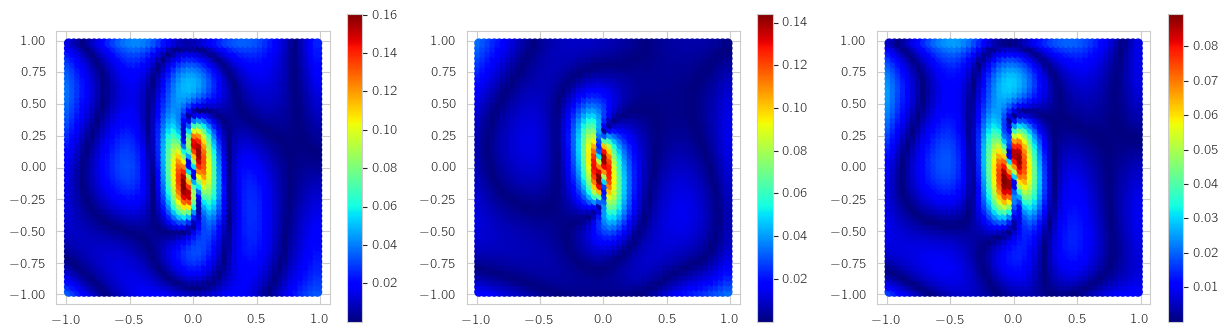

In [54]:
erreurz = torch.abs(z_hat - torch.as_tensor(data[:,2:5]))
im,ax = plt.subplots(1,3,figsize=(15,10))
for i in range(3):
    pc=ax[i].scatter(mesh[:,0],mesh[:,1],c = erreurz[:,i],cmap='jet')
    ax[i].axis('square')
    im.colorbar(pc,ax=ax[i],shrink=0.4)
plt.show()

In [12]:
start = time.time()
critere1 = error[:,0]
critere2 = error[:,1]
data1,grid1,data2,grid2 = observer.iterate2(grid,critere1,grid,critere2)
end = time.time()
print("temps de génération des données : ",int((end - start) / 60), "min et", end - start - 60 * int((end - start) / 60), "s")

temps de génération des données :  8 min et 50.337570667266846 s


torch.Size([2127, 5])
torch.Size([2148, 5])


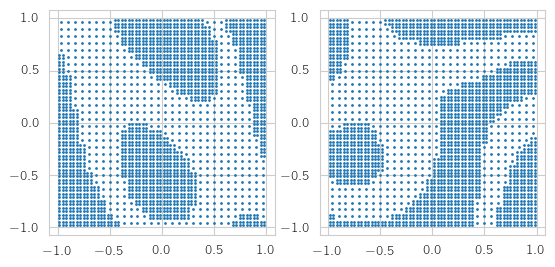

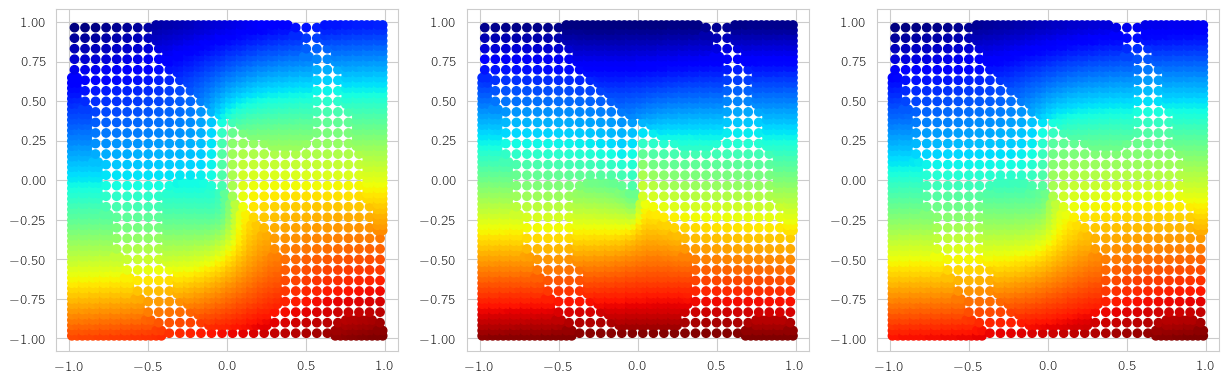

In [19]:
print(data1.shape)
print(data2.shape)
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(data1[:,0],data1[:,1],s=1)
ax1.axis('square')
ax2.scatter(data2[:,0],data2[:,1],s=1)
ax2.axis('square')
plt.show()

im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(data1[:,0],data1[:,1],c = data1[:,2+i],cmap='jet')
    ax[i].axis('square')
plt.show()

In [15]:
datax1, val_data1 = train_test_split(data1, test_size=0.3, shuffle=True)
datax2, val_data2 = train_test_split(data2, test_size=0.3, shuffle=True)

In [16]:
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=datax1,
                    validation_data=val_data1, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_56/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_56


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.


In [17]:
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=datax1,
                         validation_data=val_data1, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_56/tb_logs\lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_26


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RMSE :  [0.00654553 0.00047423]


C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\3504570582.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[0],shrink=0.3)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\3504570582.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[1],shrink=0.3)


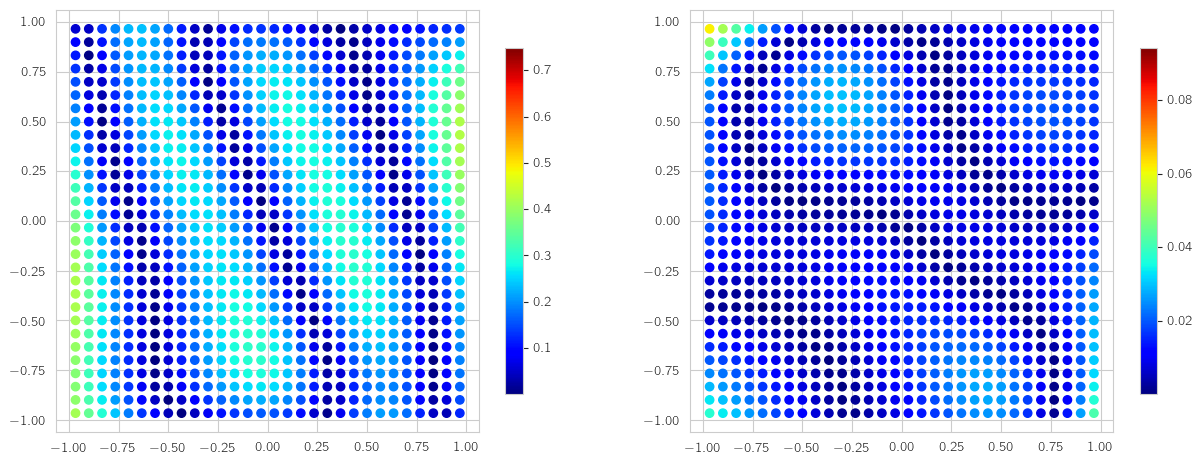

In [25]:
# prediction avec grille raffinée
L,N,O = np.array([2,2]),np.array([30,30]),np.array([-1,-1])
geometry = [L,N,O]
grid_test = init_grid(geometry)
mesh = coordinate(grid_test)
mesh = torch.as_tensor(mesh)
z_hat = observer.encoder(mesh).detach()
x_hat = observer.decoder(z_hat).detach()
error = torch.abs(mesh-x_hat)
rmse = np.array([torch.sqrt((error[:,0]**2).sum()),torch.sqrt((error[:,1]**2).sum())])/error[:,0].size()
print("RMSE : ",rmse)

im,ax = plt.subplots(1,2,figsize=(15,15))
pc=ax[0].scatter(mesh[:,0],mesh[:,1],c = error[:,0],cmap='jet',vmin=vmin1,vmax=vmax1)
ax[0].axis('square')
im.colorbar(pc,ax=ax[0],shrink=0.3)
pc=ax[1].scatter(mesh[:,0],mesh[:,1],c = error[:,1],cmap='jet',vmin=vmin2,vmax=vmax2)
ax[1].axis('square')
im.colorbar(pc,ax=ax[1],shrink=0.3)
plt.show()

In [27]:
# données uniformes de même taille
data_uni,_ = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [len(grid1),1],
                                  method='uniform')
data_uni, val_data_uni = train_test_split(data_uni, test_size=0.3, shuffle=True)

Computed the smallest possible uniform grid for the given dimensions, then deleted 82 samples randomly to match the desired number of samples 2127.


torch.Size([1488, 5])
2127


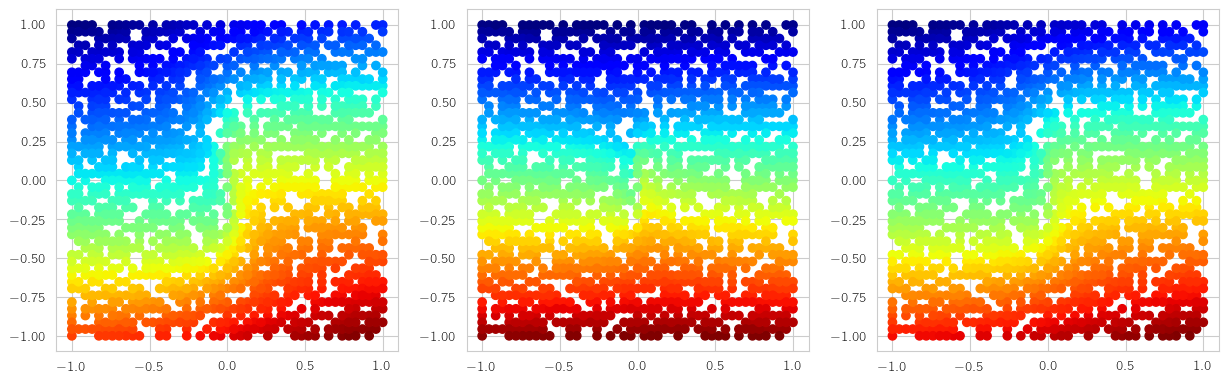

In [29]:
im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(data_uni[:,0],data_uni[:,1],c = data_uni[:,2+i],cmap='jet')
    ax[i].axis('square')
plt.show()

In [30]:
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data_uni,
                    validation_data=val_data_uni, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_57/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_57


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


In [31]:
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_uni,
                         validation_data=val_data_uni, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T\exp_57/tb_logs\lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_26


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RMSE :  [0.00636816 0.00103929]


C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\2561264507.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[0],shrink=0.3)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_7752\2561264507.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[1],shrink=0.3)


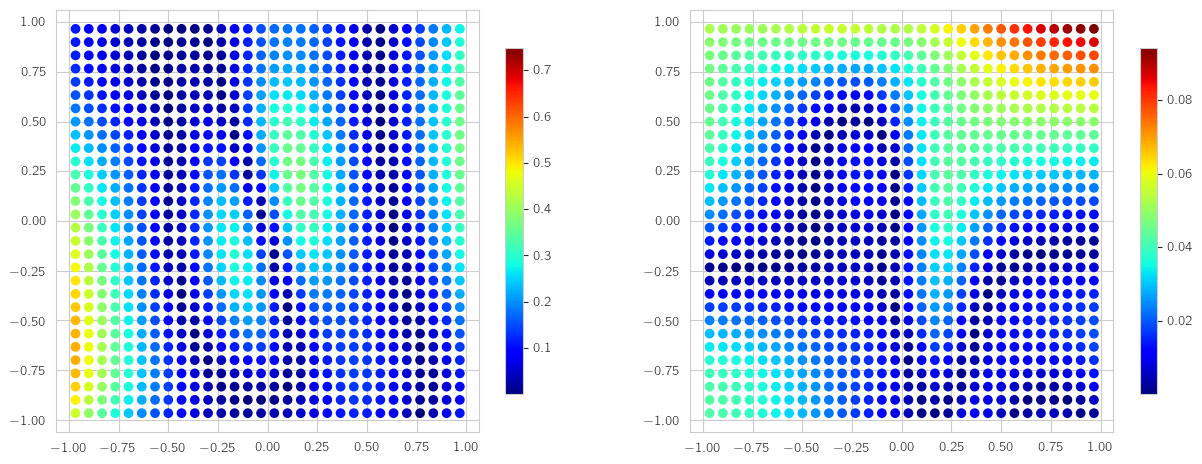

In [32]:
# prediction avec grille raffinée
L,N,O = np.array([2,2]),np.array([30,30]),np.array([-1,-1])
geometry = [L,N,O]
grid_test = init_grid(geometry)
mesh = coordinate(grid_test)
mesh = torch.as_tensor(mesh)
z_hat = observer.encoder(mesh).detach()
x_hat = observer.decoder(z_hat).detach()
error = torch.abs(mesh-x_hat)
rmse = np.array([torch.sqrt((error[:,0]**2).sum()),torch.sqrt((error[:,1]**2).sum())])/error[:,0].size()
print("RMSE : ",rmse)

im,ax = plt.subplots(1,2,figsize=(15,15))
pc=ax[0].scatter(mesh[:,0],mesh[:,1],c = error[:,0],cmap='jet',vmin=vmin1,vmax=vmax1)
ax[0].axis('square')
im.colorbar(pc,ax=ax[0],shrink=0.3)
pc=ax[1].scatter(mesh[:,0],mesh[:,1],c = error[:,1],cmap='jet',vmin=vmin2,vmax=vmax2)
ax[1].axis('square')
im.colorbar(pc,ax=ax[1],shrink=0.3)
plt.show()